In [0]:
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt

class Elevator():
    '''
    ### Args ###
    current_floor: the floor where the elevator is at
    max_capacity: capacity of the elevator (number of people allowed)
    floor_queue_outside: which floors do we need to stop in for people to get in
    floor_queue_occupancy: which floors do we need to stop in for people to get out
    people_in_elevator: a list of objects of class Person that are currently in the elevator
    occupancy: number of people in the elevator (length of people_in_elevator)
    move_up: current direction of the elevator (True if up, False if down)

    ### Methods ###
    add_occupancy: adds people to the elevator from outside
    reduce_occupancy: removes people from the elevator
    move_basic_strategy: basic strategy (described in the function)
    move_strategy3: updated strategy (described in the function)
    '''
    def __init__(self, current_floor, max_capacity, floor_queue_outside):
        self.current_floor = current_floor
        self.max_capacity = max_capacity
        self.floor_queue_occupancy = []
        self.floor_queue_outside = floor_queue_outside
        self.people_in_elevator = []
        self.occupancy = len(self.people_in_elevator)
        self.move_up = True


    def add_occupancy(self, people_in_building):
        _open = False
        # check whether the elevator is full and if there are people at this floor
#         print(self.current_floor, len(people_in_building))
        while (self.occupancy < self.max_capacity and len(people_in_building[self.current_floor]) > 0):
            # exclude the person who entered the elevator from the line
            person = people_in_building[self.current_floor].pop()
            # add the person to the ones in the elevator
            self.people_in_elevator.append(person)
            # add the floor the person who just entered needs to stop at
            self.floor_queue_occupancy.append(person.stop_floor)
            self.floor_queue_occupancy = list(set(self.floor_queue_occupancy))
            
            _open = True
        self.occupancy = len(self.people_in_elevator)
        return people_in_building, _open
    
    def reduce_occupancy(self):
        _open = False
        for person in self.people_in_elevator:
                # check whether the elevator needs to stop at the current floor
                if person.stop_floor == self.current_floor:
                    # Remove the floor from the queue of floors we need to stop at
                    if self.current_floor in self.floor_queue_occupancy:
                        self.floor_queue_occupancy.pop(self.floor_queue_occupancy.index(self.current_floor))
                    self.people_in_elevator.pop(self.people_in_elevator.index(person))
                    _open = True
        self.occupancy = len(self.people_in_elevator)
        return _open
    
    def move_basic_strategy(self, num_floors):
        '''
        Basic strategy:
        The elevator goes all the way up, then all the way down and repeat.
        '''
        
        # Elevator goes up until reaches top floor, then goes down until floor 0
        if self.current_floor == num_floors - 1:
            self.move_up = False
        elif self.current_floor == 0:
            self.move_up = True
        # Move elevator to the next floor (up or down, based on indicator)
        if self.move_up == True:
            self.current_floor += 1
        else:
            self.current_floor -= 1


    def move_strategy3(self, num_floors):
        '''
        Updated strategy:
        The elevator goes up only until where it is required to (based on the queues of passengers).
        The door opens only when required to pick up or drop off.
        '''
        
        # Join both queues (pick up and drop off) so that we can set the bounds of the floors.
        queue_all = self.floor_queue_occupancy + self.floor_queue_outside
        if queue_all:
            bound_high = max(queue_all)
            bound_low = min(queue_all)
        else:
            bound_high = num_floors - 1
            bound_low = 0 
        
        # If high bound, start moving down and vice verse
        if self.current_floor == bound_high:
            self.move_up = False
        elif self.current_floor == bound_low:
            self.move_up = True
        # Fail safe: if top floor move down, if bottom floor move up
        elif self.current_floor == num_floors - 1:
            self.move_up = False
        elif self.current_floor == 0:
            self.move_up = True
        
        # Move elevator to the next floor (up or down, based on indicator)
        if self.move_up == True:
            self.current_floor += 1
        else:
            self.current_floor -= 1

            

class Building():
    '''
    ###Args###
    num_floors: the number of floors in the building
    num_passengers: the number of people entering the elevator
    people_in_building: a list of lists, one for each floor. Each sublist contains
                        objects of class Passenger with the number of people in each
                        floor waiting for the elevator.

    ###Methods###
    extract_floor_queue_outside: collect the information about the floor destinations of the passengers
    total_current_waiting: the number of people waiting for the elevator or for their floor in the elevator
    update: update the line for the elevator after some pasengers reached their destination
    
    ###Output###
    A building object
    '''
    def __init__(self, num_floors, num_passenger, passenger_type):
        self.num_floors = num_floors
        self.num_passengers = num_passenger
        self.people_in_building = [[] for _ in range(self.num_floors)]
        self.passenger_type = passenger_type
        
        # Initiate the people
        for i in range(self.num_passengers):
            temp_person = Passenger(self.num_floors, self.passenger_type) 
            self.people_in_building[temp_person.start_floor].append(temp_person)

    def extract_floor_queue_outside(self):
        floor_queue_outside = []
        for i in range(len(self.people_in_building)):
            if len(self.people_in_building[i]) > 0:
                floor_queue_outside.append(i)
        return floor_queue_outside

    def total_current_waiting(self):
        counter = 0
        # get the total number of people that need to get to a different floor 
        for f in range(len(self.people_in_building)):
            counter += len(self.people_in_building[f])
        return counter

    def update(self, _people_in_building):
        self.people_in_building = _people_in_building

class Passenger():
    '''
    ###Args###:
    num_floor: Number of floors the passenger in the building
    passenger_type: Uniform or ground (else..).
                    If uniform, the floor is chosen from a distribution with the same 
                    probability for all floors.
                    If ground, The floor is chosen from a distribution with the same 
                    probability for all floors apart from the zero floor which has a 
                    probability larger by a factor of num_floor (the probability of 
                    the zero floor is equal to the sum of probabilities of all other floors).
    start_floor: The floor that the passenger leaves from, set by the distribution 
                 determined by the passenger parameter.
    stop_floot: The floor that the passenger needs to get to, set by the distribution
                determined by the passenger parameter.
    
    ###Output###:
    A passenger object
    '''
    def __init__(self, num_floor, passenger_type): 
        if passenger_type == 'uniform':
            self.start_floor = int(sts.uniform(0, num_floor).rvs())
            self.stop_floor = int(sts.uniform(0, num_floor).rvs())
            self.start_floor = np.random.choice(range(num_floor))
            self.stop_floor = np.random.choice(range(num_floor))
            while self.stop_floor == self.start_floor: 
                self.stop_floor = np.random.choice(range(num_floor))
        else:
            floor_list = np.zeros(num_floor)
            floor_list = np.concatenate((floor_list, range(1, num_floor)), axis=0)
            self.start_floor = int(np.random.choice(floor_list))
            self.stop_floor = int(np.random.choice(floor_list))
            while self.stop_floor == self.start_floor: 
                self.stop_floor = int(np.random.choice(floor_list))

class Simulator_1():
    '''
    Simulator for the first strategy - The elevator goes all the way up,
    then all the way down and repeat, openning the door only when 
    required to pick up or drop off.
    
    ###Args###
    num_floors: number of floors in the building
    num_passengers: number of passengers taking the elevator
    total_waiting_time: the cumulative waiting time for all passengers
    passenger_type: Uniform or ground (else..), determines the distribution
                    of floors (see passenger class for explanation).
    
    '''
    def __init__(self, num_floors, num_passengers, passenger_type): 
        self.time = 0
        self.num_floors = num_floors
        self.num_passengers = num_passengers
        self.total_waiting_time = 0
        self.passenger_type = passenger_type


    def simulate(self): 
        #Initialization
        building = Building(self.num_floors, self.num_passengers, self.passenger_type)
        elevator = Elevator(current_floor=0, max_capacity=10, floor_queue_outside = building.extract_floor_queue_outside())
        
        #Main loop
        initiate = True
        while building.total_current_waiting() > 0 or (elevator.occupancy > 0 or initiate):
            initiate = False
            # Elevator goes up until reaches top floor, then goes down until floor 0.
            
            
            elevator.move_basic_strategy(building.num_floors)
            
            # Drop all people that need this floor
            isOpen_reduce = elevator.reduce_occupancy()
            
            # Picking up people from the floor
            new_people_in_building, isOpen_add = elevator.add_occupancy(building.people_in_building)
            building.update(new_people_in_building)
            
            # if we opened the door for adding or for dropping
            if isOpen_reduce or isOpen_add:
                self.time += 1
                self.total_waiting_time += building.total_current_waiting() + elevator.occupancy
            
            # Adding the waiting time of all people in this time step to the total
            self.time += 1
            self.total_waiting_time += building.total_current_waiting() + elevator.occupancy
            
            # Update the queue of floors to visit
            elevator.floor_queue_outside = building.extract_floor_queue_outside()
        return self.total_waiting_time, self.time
            
class Simulator_2():
    '''
    Simulator for the second strategy - The elevator goes up only until 
    where it is required to (based on the queues of passengers).
    The door opens only when required to pick up or drop off.
    
    ###Args###
    num_floors: number of floors in the building
    num_passengers: number of passengers taking the elevator
    total_waiting_time: the cumulative waiting time for all passengers
    passenger_type: Uniform or ground (else..), determines the distribution
                    of floors (see passenger class for explanation).
    
    '''
    def __init__(self, num_floors, num_passengers, passenger_type): 
        self.time = 0
        self.num_floors = num_floors
        self.num_passengers = num_passengers
        self.total_waiting_time = 0
        self.passenger_type = passenger_type


    def simulate(self): 
        #Initialization
        building = Building(self.num_floors, self.num_passengers, self.passenger_type)
        elevator = Elevator(current_floor=0, max_capacity=10, floor_queue_outside = building.extract_floor_queue_outside())
        
        #Main loop
        initiate = True
        while building.total_current_waiting() > 0 or (elevator.occupancy > 0 or initiate):
            initiate = False
            # Elevator goes up until reaches top floor, then goes down until floor 0.
            elevator.move_strategy3(building.num_floors)
            
            # Drop all people that need this floor
            isOpen_reduce = elevator.reduce_occupancy()
            
            # Picking up people from the floor
            new_people_in_building, isOpen_add = elevator.add_occupancy(building.people_in_building)
            building.update(new_people_in_building)
            
            # if we opened the door for adding or for dropping
            if isOpen_reduce or isOpen_add:
                self.time += 1
                self.total_waiting_time += building.total_current_waiting() + elevator.occupancy
            
            # Adding the waiting time of all people in this time step to the total
            self.time += 1
            self.total_waiting_time += building.total_current_waiting() + elevator.occupancy
            
            # Update the queue of floors to visit
            elevator.floor_queue_outside = building.extract_floor_queue_outside()
        return self.total_waiting_time, self.time
    
class Simulator_3():
    '''
    Simulator for the third strategy - The elevator goes all the way up,
    then all the way down and repeat, openning the door at every floor.
    
    ###Args###
    num_floors: number of floors in the building
    num_passengers: number of passengers taking the elevator
    total_waiting_time: the cumulative waiting time for all passengers
    passenger_type: Uniform or ground (else..), determines the distribution
                    of floors (see passenger class for explanation).
    
    '''
    def __init__(self, num_floors, num_passengers, passenger_type): 
        self.time = 0
        self.num_floors = num_floors
        self.num_passengers = num_passengers
        self.total_waiting_time = 0
        self.passenger_type = passenger_type

    def simulate(self): 
        #Initialization
        building = Building(self.num_floors, self.num_passengers, self.passenger_type)
        elevator = Elevator(current_floor=0, max_capacity=10, floor_queue_outside = building.extract_floor_queue_outside)
        
        #Main loop
        initiate = True
        while building.total_current_waiting() > 0 or (elevator.occupancy > 0 or initiate):
            initiate = False
    
            # Drop all people that need this floor
            isOpen_reduce = elevator.reduce_occupancy()
            
            # Picking up people from the floor
            new_people_in_building, isOpen_add = elevator.add_occupancy(building.people_in_building)
            building.update(new_people_in_building)
            
            
            # if we opened the door for adding or for dropping
            if True:
                self.time += 1
                self.total_waiting_time += building.total_current_waiting() + elevator.occupancy
                
            # Elevator goes up until reaches top floor, then goes down until floor 0.            
            elevator.move_basic_strategy(building.num_floors)
            
            # Adding the waiting time of all people in this time step to the total
            self.time += 1
            self.total_waiting_time += building.total_current_waiting() + elevator.occupancy
        return self.total_waiting_time, self.time


simulator1 = Simulator_2(num_floors=10, num_passengers=30, passenger_type = 'uniform')
simulator1.simulate()

(752, 59)

In [0]:
strategies = [[] for _ in range(12)] 
arr = np.arange(10, 300, 10, dtype = 'int')
passenger_type_array = ['uniform', 'non-uniform']

In [0]:
for a in arr: 
    simulator1 = Simulator_1(num_floors=a, num_passengers=30, passenger_type = 'uniform')
    simulator1.simulate()
    strategies[0].append(simulator1.total_waiting_time)

    simulator2 = Simulator_2(num_floors=a, num_passengers=30, passenger_type = 'uniform')
    simulator2.simulate()
    strategies[1].append(simulator2.total_waiting_time)

    simulator3 = Simulator_3(num_floors=a, num_passengers=30, passenger_type = 'uniform')
    simulator3.simulate()
    strategies[2].append(simulator3.total_waiting_time)

    simulator1 = Simulator_1(num_floors=20, num_passengers=a, passenger_type = 'uniform')
    simulator1.simulate()
    strategies[3].append(simulator1.total_waiting_time)

    simulator2 = Simulator_2(num_floors=20, num_passengers=a, passenger_type = 'uniform')
    simulator2.simulate()
    strategies[4].append(simulator2.total_waiting_time)

    simulator3 = Simulator_3(num_floors=20, num_passengers=a, passenger_type = 'uniform')
    simulator3.simulate()
    strategies[5].append(simulator3.total_waiting_time)
    
    simulator1 = Simulator_1(num_floors=a, num_passengers=30, passenger_type = 'non-uniform')
    simulator1.simulate()
    strategies[6].append(simulator1.total_waiting_time)

    simulator2 = Simulator_2(num_floors=a, num_passengers=30, passenger_type = 'non-uniform')
    simulator2.simulate()
    strategies[7].append(simulator2.total_waiting_time)

    simulator3 = Simulator_3(num_floors=a, num_passengers=30, passenger_type = 'non-uniform')
    simulator3.simulate()
    strategies[8].append(simulator3.total_waiting_time)

    simulator1 = Simulator_1(num_floors=20, num_passengers=a, passenger_type = 'non-uniform')
    simulator1.simulate()
    strategies[9].append(simulator1.total_waiting_time)

    simulator2 = Simulator_2(num_floors=20, num_passengers=a, passenger_type = 'non-uniform')
    simulator2.simulate()
    strategies[10].append(simulator2.total_waiting_time)

    simulator3 = Simulator_3(num_floors=20, num_passengers=a, passenger_type = 'non-uniform')
    simulator3.simulate()
    strategies[11].append(simulator3.total_waiting_time)


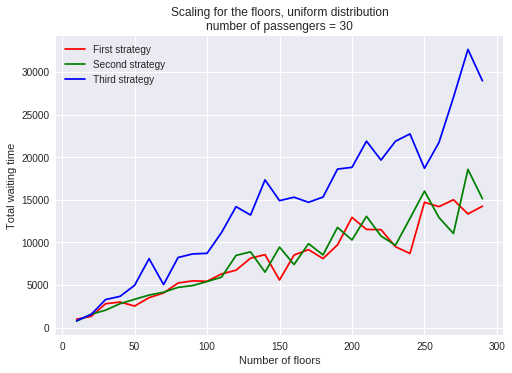

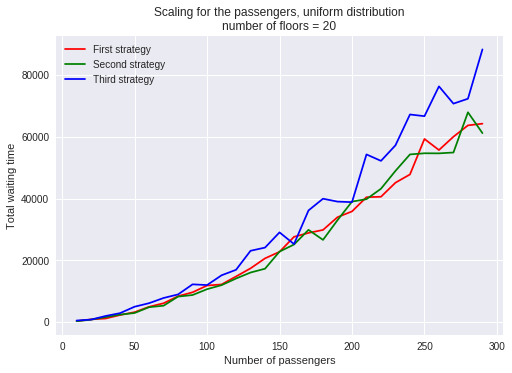

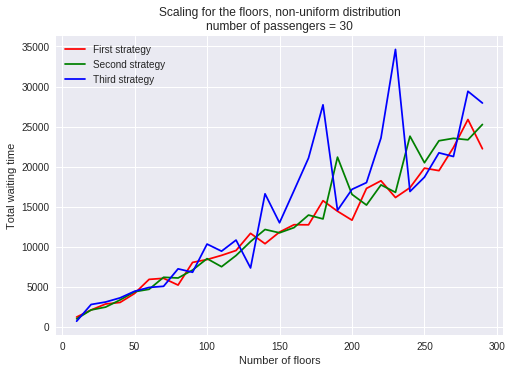

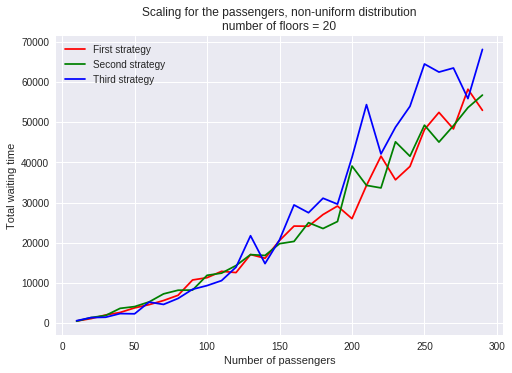

In [0]:
i_1 = [0, 3, 6, 9]
i_2 = [1, 4, 7, 10]
i_3 = [2, 5, 8, 11]
title = ['Scaling for the floors, uniform distribution\nnumber of passengers = 30', 'Scaling for the passengers, uniform distribution\nnumber of floors = 20', 
         'Scaling for the floors, non-uniform distribution\nnumber of passengers = 30', 'Scaling for the passengers, non-uniform distribution\nnumber of floors = 20',]
x_labels = ['Number of floors', 'Number of passengers'] * 2
for i in range(4):

    y_1 = strategies[i_1[i]]
    y_2 = strategies[i_2[i]]
    y_3 = strategies[i_3[i]]


    plt.plot(arr, y_1, label = 'First strategy', color = 'r')
    plt.plot(arr, y_2, label = 'Second strategy', color = 'g')
    plt.plot(arr, y_3, label = 'Third strategy', color = 'b')

    plt.xlabel(x_labels[i])
    plt.ylabel('Total waiting time')
    plt.title(title[i])

    plt.legend()
    plt.show()
